In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Importing necessary functions
from activations import *
from utils import *
from model_utils import *

In [3]:
#reading dataset from csv format
df = pd.read_csv("dataset_NN.csv")
df["class"] = df["class"] - 1
df.head()
df.shape

(2000, 7)

In [4]:
#shuffling the dataset to avoid bias
df = df.sample(frac=1)
df.head()

,att1,att2,att3,att4,att5,att6,class
707,0.0,2.0,0.0,154.082861,1.794033,6626.833373,3
545,0.0,2.0,0.0,188.678861,2.059350,11500.401738,2
1053,0.0,2.0,0.0,174.220861,2.028505,9504.139244,5
1235,1.0,1.0,1.0,135.648861,1.462062,3736.662912,6
375,0.0,2.0,0.0,131.545861,1.280362,2864.290187,1


In [5]:
#normalisation
df_minmax = (df - df.min())/(df.max() - df.min())
df_minmax.head()

,att1,att2,att3,att4,att5,att6,class
707,0.0,0.333333,0.0,0.414167,0.459774,0.321540,0.333333
545,0.0,0.333333,0.0,0.676720,0.647185,0.623633,0.222222
1053,0.0,0.333333,0.0,0.566997,0.625398,0.499893,0.555556
1235,0.5,0.166667,0.2,0.274270,0.225282,0.142390,0.666667
375,0.0,0.333333,0.0,0.243132,0.096935,0.088315,0.111111


In [6]:
#Splitting dataset into 70-30
df_train_norm = df_minmax[0:1400]
df_test_norm = df_minmax[1400:]

df_train = df[0:1400]
df_test = df[1400:]

In [7]:
#splitting normalised data
x_train = np.array(df_train.drop(columns="class"))
y_train = np.array(df_train["class"])

x_train_norm = np.array(df_train_norm.drop(columns="class"))
y_train_norm = np.array(df_train["class"])

x_test = np.array(df_test.drop(columns="class"))
y_test = np.array(df_test["class"])

x_test_norm = np.array(df_test_norm.drop(columns="class"))
y_test_norm = np.array(df_test["class"])

In [8]:
#y_train

In [9]:
X_train = x_train.T
X_test = x_test.T

X_train_norm = x_train_norm.T
X_test_norm = x_test_norm.T
'''print("TRAIN  SHAPE:", X_train.shape)
print("TEST NSHAPE:",X_test.shape)
print("TRAIN NORM SHAPE:", X_train_norm.shape)
print("TEST NORM SHAPE:",X_test_norm.shape)
#print(y_train_norm.shape)
#print(y_test_norm.shape)'''

class_labels = np.unique(y_train)
print(class_labels.shape)
# Converting to a one hot matrix
Y_hot = one_hot(y_train)
'''print ("Dimensions of X (Features(n) x Examples(m)):",X_train.shape)
print ("\nDiemsions of Y:",Y_hot.shape)'''

(10,)


'print ("Dimensions of X (Features(n) x Examples(m)):",X_train.shape)\nprint ("\nDiemsions of Y:",Y_hot.shape)'

In [10]:
#class_labels

In [11]:
# Assinging the samples to 'testX' and labels to 'testY'
# Reshaping testX as (n x m) --> (Features x samples)
testX = X_test
test_Xnorm = X_test_norm
#testY = np.array(testY)
testY_hot = one_hot(y_test)
'''print ("Diemsions of testX:",testX.shape)
print ("Diemsions of testX_norm:",test_Xnorm.shape)
print ("Diemsions of testX=Y:",testY_hot.shape)
#print ("Diemsions of testX=Y_norm:",testY_hot.shape)'''

'print ("Diemsions of testX:",testX.shape)\nprint ("Diemsions of testX_norm:",test_Xnorm.shape)\nprint ("Diemsions of testX=Y:",testY_hot.shape)\n#print ("Diemsions of testX=Y_norm:",testY_hot.shape)'

In [12]:
# Function To form Mini-batches
def random_mini_batches(X,Y,batch_size = 64):
    
    mini_batches = []
    m = X.shape[1]
    # Shuffle
    permute = np.random.permutation(m)
    X = X[:,permute]
    Y = Y[:,permute]
    
    # Partition
    complete_batches = math.floor(m/batch_size)
    for k in range(complete_batches):
        batch_X = X[:,k*batch_size:(k+1)*batch_size]
        batch_Y = Y[:,k*batch_size:(k+1)*batch_size]
        batch = (batch_X,batch_Y)
        mini_batches.append(batch)
        
    # Handling the end case
    if m % batch_size != 0:
        batch_X = X[:,(k+1)*batch_size:]
        batch_Y = Y[:,(k+1)*batch_size:]
        batch = (batch_X,batch_Y)
        mini_batches.append(batch)
        
    return mini_batches

In [13]:
# Function to implement Neural Network using Mini-batch GD
def model(X,Y, y_train, layer_dims,alpha=0.01,batch_size=128,num_epochs=1000
          ,lamb=0,print_cost=True,grad_check=False):
    
    params = params_init(layer_dims)
    v,s = init_for_adam(params)
    t = 0
    hist_cost=[]
    hist_acc=[]
    epoch_choice = np.random.choice(num_epochs,2)
    
    num_batches = np.ceil(X.shape[1]/batch_size)
    
    for i in range(num_epochs):
        epoch_cost = 0 
        minibatches = random_mini_batches(X,Y,batch_size)
        iter_check = 0
        lr = learningRate_decay(alpha,i)
        #using mini-batch GD
        for mini_b in minibatches:
            (mini_x,mini_y) = mini_b
            
            #Forward-Propogation Step
            AL,caches = forward_prop(mini_x,params)
            AL = np.clip(AL,a_min=1e-10,a_max=None)
            reg_term = l2regularization(params,lamb)
            cost = costFunction(AL,mini_y,reg_term)
            epoch_cost += cost 
            
            #Back-Propogation Step
            grads = backprop(AL,mini_y,caches,params,lamb)
            
            #Updating Parameters
            if grad_check and i in epoch_choice  and iter_check <3:
                gradient_check(mini_x,mini_y,params,grads)
                iter_check +=1
            t += 1
            params,v,s = update_parameters_with_adam(params,grads,v,s,t,lr)
      
        #Ypred = predictions(AL)
       # print("Y:",Y)
       # print("pred:",AL)
        
        #printing cost and accuracies after every 50 epochs
        hist_cost.append(epoch_cost/num_batches)
        if i%50 == 0 and print_cost:
            print ("Cost after epoch %i: %f" %(i, epoch_cost/num_batches))
        hist_acc.append(acc_it(X,y_train,params))    
        if i%50 == 0:
            print("accuracy after epoch %i: %f" %(i, acc_it(X,y_train,params)))
            
    #print("Y:", y_train)
    #axe = acc_it(X,y_train,params)     
    #print("AACC",axe)
    
    #print
    if alpha == 0.1:        
        plt.plot(np.squeeze(hist_cost))
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.title('Starting Learing Rate = '+ str(alpha))
        plt.show()
    
          
        #plt.plot(np.squeeze(hist_acc))
       # plt.ylabel('Accuarcy')
        #plt.xlabel('Epochs')
       # plt.title('Starting Learing Rate = '+ str(alpha))
       # plt.show()'''
        
    return params, hist_acc

In [14]:
# NN with 1 hidden layer
# No. of classes = 10 units in the output layer, 256, 128 in Hidden Layers
layer_dims = [X_train.shape[0],256,128,Y_hot.shape[0]]


Neural Network with 2 hidden layers

For Learning rate: 0.1
Cost after epoch 0: 4.525883
accuracy after epoch 0: 50.142857
Cost after epoch 50: 0.527413
accuracy after epoch 50: 76.571429
Cost after epoch 100: 0.468777
accuracy after epoch 100: 79.142857
Cost after epoch 150: 0.458030
accuracy after epoch 150: 79.214286
Cost after epoch 200: 0.424645
accuracy after epoch 200: 80.571429
Cost after epoch 250: 0.398140
accuracy after epoch 250: 81.857143
Cost after epoch 300: 0.378040
accuracy after epoch 300: 82.500000
Cost after epoch 350: 0.365842
accuracy after epoch 350: 82.928571
Cost after epoch 400: 0.353925
accuracy after epoch 400: 82.857143
Cost after epoch 450: 0.348374
accuracy after epoch 450: 83.500000
Cost after epoch 500: 0.342462
accuracy after epoch 500: 83.500000
Cost after epoch 550: 0.339808
accuracy after epoch 550: 83.642857
Cost after epoch 600: 0.337964
accuracy after epoch 600: 83.714286
Cost after epoch 650: 0.334669
accuracy after epoch 650: 83.928571
Cost af

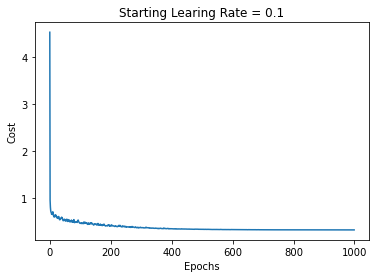

Accuracy on the Training Set: 84.07 %
Accuracy on the Test Set: 72.17 %
Neural Network made errors in predicting 167 samples out of 600 in the Test Set 

For Learning rate: 0.01
Cost after epoch 0: 1.474246
accuracy after epoch 0: 54.500000
Cost after epoch 50: 0.508543
accuracy after epoch 50: 78.357143
Cost after epoch 100: 0.461994
accuracy after epoch 100: 79.642857
Cost after epoch 150: 0.438871
accuracy after epoch 150: 81.142857
Cost after epoch 200: 0.415584
accuracy after epoch 200: 82.071429
Cost after epoch 250: 0.404275
accuracy after epoch 250: 82.642857
Cost after epoch 300: 0.395824
accuracy after epoch 300: 83.142857
Cost after epoch 350: 0.388226
accuracy after epoch 350: 83.428571
Cost after epoch 400: 0.382826
accuracy after epoch 400: 83.642857
Cost after epoch 450: 0.377224
accuracy after epoch 450: 83.785714
Cost after epoch 500: 0.374205
accuracy after epoch 500: 83.928571
Cost after epoch 550: 0.372503
accuracy after epoch 550: 84.000000
Cost after epoch 600: 0.

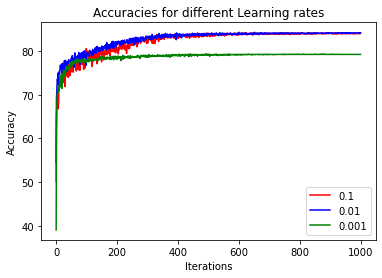

In [15]:
#Implementing NN for 3 learning rates and plotting accuracies over iterations
print("\nNeural Network with 2 hidden layers")
lr = [0.1,0.01,0.001]
color = ['r','b','g']
k=0

for i in lr:
    print("\nFor Learning rate:",i)
    params1, accs = model(X_train_norm,Y_hot,y_train, layer_dims,i,num_epochs=1000,batch_size=128)
    accuracy(X_train_norm,y_train,test_Xnorm,y_test,params1)
    plt.plot(accs,color[k],label = i)
    k+=1
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title("Accuracies for different Learning rates")
plt.legend()
plt.show()
print("\n")


Neural Network with 1 hidden layer

For Learning rate: 0.1
Cost after epoch 0: 1.490283
accuracy after epoch 0: 61.642857
Cost after epoch 50: 0.619876
accuracy after epoch 50: 71.142857
Cost after epoch 100: 0.532622
accuracy after epoch 100: 76.714286
Cost after epoch 150: 0.522931
accuracy after epoch 150: 77.214286
Cost after epoch 200: 0.497784
accuracy after epoch 200: 77.285714
Cost after epoch 250: 0.488429
accuracy after epoch 250: 78.785714
Cost after epoch 300: 0.480302
accuracy after epoch 300: 78.857143
Cost after epoch 350: 0.469082
accuracy after epoch 350: 79.714286
Cost after epoch 400: 0.464045
accuracy after epoch 400: 80.142857
Cost after epoch 450: 0.464512
accuracy after epoch 450: 80.071429
Cost after epoch 500: 0.460198
accuracy after epoch 500: 80.071429
Cost after epoch 550: 0.458721
accuracy after epoch 550: 80.285714
Cost after epoch 600: 0.458247
accuracy after epoch 600: 80.071429
Cost after epoch 650: 0.457051
accuracy after epoch 650: 80.142857
Cost aft

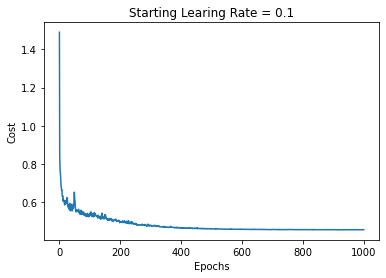

Accuracy on the Training Set: 80.36 %
Accuracy on the Test Set: 72.67 %
Neural Network made errors in predicting 164 samples out of 600 in the Test Set 

For Learning rate: 0.01
Cost after epoch 0: 1.809918
accuracy after epoch 0: 51.642857
Cost after epoch 50: 0.575219
accuracy after epoch 50: 76.857143
Cost after epoch 100: 0.540813
accuracy after epoch 100: 77.071429
Cost after epoch 150: 0.533029
accuracy after epoch 150: 77.642857
Cost after epoch 200: 0.521318
accuracy after epoch 200: 78.000000
Cost after epoch 250: 0.519324
accuracy after epoch 250: 77.500000
Cost after epoch 300: 0.514860
accuracy after epoch 300: 77.642857
Cost after epoch 350: 0.514180
accuracy after epoch 350: 77.857143
Cost after epoch 400: 0.511690
accuracy after epoch 400: 77.642857
Cost after epoch 450: 0.510912
accuracy after epoch 450: 77.785714
Cost after epoch 500: 0.510859
accuracy after epoch 500: 78.071429
Cost after epoch 550: 0.509552
accuracy after epoch 550: 77.785714
Cost after epoch 600: 0.

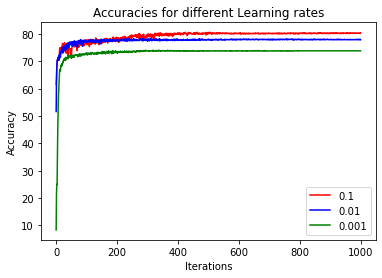

In [16]:
# Implementing NN with 1 hidden layer
# No. of classes = 10 units in the output layer, 128 in Hidden Layer
print("\nNeural Network with 1 hidden layer")
layer_dims = [X_train.shape[0],128,Y_hot.shape[0]]
lr = [0.1,0.01,0.001]
color = ['r','b','g']
k=0

for i in lr:
    print("\nFor Learning rate:",i)
    params1, accs = model(X_train_norm,Y_hot,y_train, layer_dims,i,num_epochs=1000,batch_size=128)
    accuracy(X_train_norm,y_train,test_Xnorm,y_test,params1)
    plt.plot(accs,color[k],label = i)
    k+=1
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title("Accuracies for different Learning rates")
plt.legend()
plt.show()